In [28]:
import pandas as pd
import numpy as np
import base64
import string
import re
from collections import Counter
import spacy
from nltk.corpus import stopwords
import random
from spacy.util import minibatch

In [4]:
import nltk
nltk.download('stopwords')


stopwords = stopwords.words('english')

[nltk_data] Downloading package stopwords to /Users/daaa/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [9]:
df = pd.read_csv('ticketClassification.csv')

In [10]:
df.head()

,Unnamed: 0,text,label
0,0,Technical issue Product setup I'm having an is...,3
1,1,Technical issue Peripheral compatibility I'm h...,3
2,2,Technical issue Network problem I'm facing a p...,0
3,3,Billing inquiry Account access I'm having an i...,0
4,4,Billing inquiry Data loss I'm having an issue ...,0


In [41]:
df.text.head(1)

0    Technical issue Product setup I'm having an is...
Name: text, dtype: object

In [12]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.33, random_state=42)

In [18]:
df['label'].value_counts() # dataset is balanced :)

label
1    2192
3    2129
2    2085
0    2063
Name: count, dtype: int64

In [24]:
nlp = spacy.load('en_core_web_sm')

In [25]:
def convert_df(df):
    return df.apply(lambda row: (row['text'], {"cats": {row['label']: 1}}), axis=1).tolist()

train_data = convert_df(train)
test_data = convert_df(test)

In [34]:
from spacy.training import Example

def convert_to_example(df):
    examples = []
    for text, annot in df:
        doc = nlp.make_doc(text)
        example = Example.from_dict(doc, annot)
        examples.append(example)
    return examples

train_data = convert_df(train)
train_examples = convert_to_example(train_data)

# Start training
optimizer = nlp.begin_training()

for i in range(10):
    losses = {}
    batches = minibatch(train_examples, size=compounding(4.0, 32.0, 1.001))
    for batch in batches:
        nlp.update(batch, sgd=optimizer, drop=0.2, losses=losses)
    print("Losses", losses)


Losses {'textcat': 58.0625}
Losses {'textcat': 58.0625}
Losses {'textcat': 58.0625}
Losses {'textcat': 58.0625}
Losses {'textcat': 58.0625}
Losses {'textcat': 58.0625}
Losses {'textcat': 58.0625}
Losses {'textcat': 58.0625}
Losses {'textcat': 58.0625}
Losses {'textcat': 58.0625}


In [37]:
# Convert the test data to `Example` objects
test_data = convert_df(test)
test_examples = convert_to_example(test_data)

# Use the model to predict the test data
correct_predictions = 0
total_predictions = 0

for example in test_examples:
    # Use the model to predict the text
    doc = nlp(example.text)
    predicted_label = max(doc.cats, key=doc.cats.get)  # Get the label with the highest score

    # Get the actual label
    actual_label = max(example.cats, key=example.annotation.cats.get)
    
    # If the predicted label matches the actual label, increment correct_predictions
    if predicted_label == actual_label:
        correct_predictions += 1

    total_predictions += 1

# Print the accuracy
print(f"Accuracy: {correct_predictions/total_predictions:.2f}")


AttributeError: 'spacy.training.example.Example' object has no attribute 'cats'

In [52]:
from sklearn.metrics import accuracy_score

# Prepare the test data
test_data = convert_df(test)
test_examples = convert_to_example(test_data)

# Get the true labels
true_labels = [max(example.y.cats, key=example.y.cats.get) for example in test_examples]

# Predict the labels with the model
predicted_labels = []
for example in test_examples:
    doc = nlp(example.text)
    predicted_labels.append(max(doc.cats, key=doc.cats.get))

# Ensure the labels are in the same format
true_labels = [str(label) for label in true_labels]
predicted_labels = [str(label) for label in predicted_labels]

# Calculate the accuracy
accuracy = accuracy_score(true_labels, predicted_labels)

print(f'Test Accuracy: {accuracy*100:.2f}%')




Test Accuracy: 0.00%


In [53]:
print("True labels:", true_labels[:10]) 
print("Predicted labels:", predicted_labels[:10])


True labels: ['2', '0', '0', '2', '1', '0', '1', '2', '2', '0']
Predicted labels: ['Low', 'Low', 'Low', 'Low', 'Low', 'Low', 'Low', 'Low', 'Low', 'Low']


In [1]:
from datasets import load_dataset
from sentence_transformers.losses import CosineSimilarityLoss

from setfit import SetFitModel, SetFitTrainer


/Users/daaa/Downloads/KAKI-App/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
dataset = load_dataset('csv', data_files="ticketClassification.csv", split='train')

Found cached dataset csv (/Users/daaa/.cache/huggingface/datasets/csv/default-3ccb1e3336d246a2/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d)


In [13]:
dataset

Dataset({
    features: ['Unnamed: 0', 'text', 'label'],
    num_rows: 8469
})

In [16]:
stratify_column_name = "label"

dataset.class_encode_column(
    stratify_column_name
).train_test_split(
    test_size=0.2, 
    stratify_by_column=stratify_column_name
)


DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'text', 'label'],
        num_rows: 6775
    })
    test: Dataset({
        features: ['Unnamed: 0', 'text', 'label'],
        num_rows: 1694
    })
})

In [22]:
# Select N examples per class (8 in this case)
# train_ds = dataset["train"]
# test_ds = dataset["test"]

split_data = dataset.train_test_split(test_size=0.2)

In [23]:
train_ds = split_data['train']
test_ds = split_data['test']

In [25]:
# Load SetFit model from Hub
model = SetFitModel.from_pretrained("sentence-transformers/paraphrase-mpnet-base-v2")

# Create trainer
trainer = SetFitTrainer(
    model=model,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    loss_class=CosineSimilarityLoss,
    batch_size=16,
    num_iterations=20, # Number of text pairs to generate for contrastive learning
    num_epochs=1 # Number of epochs to use for contrastive learning
)


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


In [26]:
# Train and evaluate!
trainer.train()
metrics = trainer.evaluate()

Generating Training Pairs: 100%|██████████| 20/20 [00:02<00:00,  8.40it/s]
***** Running training *****
  Num examples = 271000
  Num epochs = 1
  Total optimization steps = 16938
  Total train batch size = 16
Epoch:   0%|          | 0/1 [25:04<?, ?it/s]


KeyboardInterrupt: 

In [1]:
import pandas as pd

In [4]:
df = pd.read_csv("ticketClassification.csv")

In [7]:
df = df.drop(columns=["row_id"])

In [8]:
df

,text,label
0,Technical issue Product setup I'm having an is...,3
1,Technical issue Peripheral compatibility I'm h...,3
2,Technical issue Network problem I'm facing a p...,0
3,Billing inquiry Account access I'm having an i...,0
4,Billing inquiry Data loss I'm having an issue ...,0
...,...,...
8464,Product inquiry Installation support My {produ...,0
8465,Technical issue Refund request I'm having an i...,3
8466,Technical issue Account access I'm having an i...,2
8467,Product inquiry Payment issue I'm having an is...,1


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Assuming df is your DataFrame and 'text' and 'label' are the column names

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], random_state=42)

# Create a pipeline to vectorize the data, then train and fit a model
text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()),
])

# Train the classifier
text_clf.fit(X_train, y_train)

# Test the classifier and display its accuracy score
accuracy = text_clf.score(X_test, y_test)
print(f"Model accuracy: {accuracy}")


Model accuracy: 0.2469310670443815


In [10]:
from sklearn.svm import LinearSVC

# Create a pipeline to vectorize the data, then train and fit a model
text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', LinearSVC()),
])

# Train the classifier
text_clf.fit(X_train, y_train)

# Test the classifier and display its accuracy score
accuracy = text_clf.score(X_test, y_test)
print(f"Model accuracy: {accuracy}")


Model accuracy: 0.2516525023607177


/Users/daaa/Downloads/KAKI-App/venv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


In [11]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string

# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize a Lemmatizer
lemmatizer = WordNetLemmatizer()

# Define a function to handle all preprocessing
def preprocess_text(text):
    # Lowercase the text
    text = text.lower()
    # Remove punctuation
    text = ''.join([char for char in text if char not in string.punctuation])
    # Remove stopwords
    text = ' '.join([word for word in text.split() if word not in stopwords.words('english')])
    # Lemmatize the words
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])
    return text

# Apply the preprocessing to each text in your DataFrame
df['text'] = df['text'].apply(preprocess_text)


[nltk_data] Downloading package stopwords to /Users/daaa/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/daaa/nltk_data...


In [12]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.2, random_state=42)

# Create a pipeline that vectorizes the data, then trains and fits a model
text_clf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LinearSVC()),
])

# Train the classifier
text_clf.fit(X_train, y_train)

# Predict the test set results
y_pred = text_clf.predict(X_test)

# Print a classification report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.21      0.22      0.22       415
           1       0.26      0.24      0.25       459
           2       0.23      0.24      0.24       409
           3       0.22      0.23      0.22       411

    accuracy                           0.23      1694
   macro avg       0.23      0.23      0.23      1694
weighted avg       0.23      0.23      0.23      1694



/Users/daaa/Downloads/KAKI-App/venv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


In [13]:
from sklearn.linear_model import LogisticRegression

# Create a pipeline to vectorize the data, then train and fit a model
text_clf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression(solver='liblinear')),
])

# Train the classifier
text_clf.fit(X_train, y_train)

# Predict the test set results
y_pred = text_clf.predict(X_test)

# Print a classification report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.23      0.21      0.22       415
           1       0.29      0.28      0.28       459
           2       0.25      0.26      0.26       409
           3       0.26      0.28      0.27       411

    accuracy                           0.26      1694
   macro avg       0.26      0.26      0.26      1694
weighted avg       0.26      0.26      0.26      1694



In [14]:
from sklearn.tree import DecisionTreeClassifier

# Create a pipeline to vectorize the data, then train and fit a model
text_clf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', DecisionTreeClassifier()),
])

# Train the classifier
text_clf.fit(X_train, y_train)

# Predict the test set results
y_pred = text_clf.predict(X_test)

# Print a classification report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.25      0.23      0.24       415
           1       0.29      0.28      0.29       459
           2       0.24      0.26      0.25       409
           3       0.25      0.26      0.26       411

    accuracy                           0.26      1694
   macro avg       0.26      0.26      0.26      1694
weighted avg       0.26      0.26      0.26      1694



In [15]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'tfidf__use_idf': (True, False),
    'clf__C': (0.1, 1, 10),
}

# Create a pipeline
text_clf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LinearSVC()),
])

# Create a GridSearchCV object
grid_search = GridSearchCV(text_clf, param_grid, cv=5, n_jobs=-1)

# Fit the GridSearchCV object
grid_search.fit(X_train, y_train)

# Print the best parameters
print("Best parameters: ", grid_search.best_params_)

# Predict the test set results
y_pred = grid_search.predict(X_test)

# Print a classification report
print(classification_report(y_test, y_pred))


/Users/daaa/Downloads/KAKI-App/venv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/daaa/Downloads/KAKI-App/venv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/daaa/Downloads/KAKI-App/venv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/daaa/Downloads/KAKI-App/venv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress th

Best parameters:  {'clf__C': 0.1, 'tfidf__use_idf': True}
              precision    recall  f1-score   support

           0       0.23      0.21      0.22       415
           1       0.29      0.28      0.28       459
           2       0.26      0.27      0.26       409
           3       0.26      0.28      0.27       411

    accuracy                           0.26      1694
   macro avg       0.26      0.26      0.26      1694
weighted avg       0.26      0.26      0.26      1694



/Users/daaa/Downloads/KAKI-App/venv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


In [18]:
import xgboost as xgb
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.2, random_state=42)

# Create a pipeline to vectorize the data, then train and fit a model
text_clf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')),
])

# Train the classifier
text_clf.fit(X_train, y_train)

# Predict the test set results
y_pred = text_clf.predict(X_test)

# Print a classification report
print(classification_report(y_test, y_pred))


/Users/daaa/Downloads/KAKI-App/venv/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


              precision    recall  f1-score   support

           0       0.22      0.21      0.22       415
           1       0.26      0.26      0.26       459
           2       0.27      0.27      0.27       409
           3       0.24      0.24      0.24       411

    accuracy                           0.25      1694
   macro avg       0.25      0.25      0.25      1694
weighted avg       0.25      0.25      0.25      1694



  Obtaining dependency information for matplotlib from https://files.pythonhosted.org/packages/8d/22/719f4fff33b13b0708711fb52ca3fc44617a26728e0e023358288d5197ae/matplotlib-3.7.2-cp310-cp310-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for contourpy>=1.0.1 from https://files.pythonhosted.org/packages/15/c4/aae3954fce0e22362cc55430d1a395bf0be5a22b40fce63edda9eb6ea339/contourpy-1.1.0-cp310-cp310-macosx_11_0_arm64.whl.metadata
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
  Obtaining dependency information for fonttools>=4.22.0 from https://files.pythonhosted.org/packages/bf/22/3a8d523d4c97ee358e5259aa0c0812d912eec76828a0b374b5c57292fc60/fonttools-4.41.1-cp310-cp310-macosx_10_9_universal2.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.0/150.0 kB 6.6 MB/s eta 0:00:00
  Using cached kiwisolver-1.4.4-cp310-cp310-macosx_11_0_arm64.whl (63 kB)
  Using cached pyparsing-3.0.9-py3-none-any.whl (98 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3

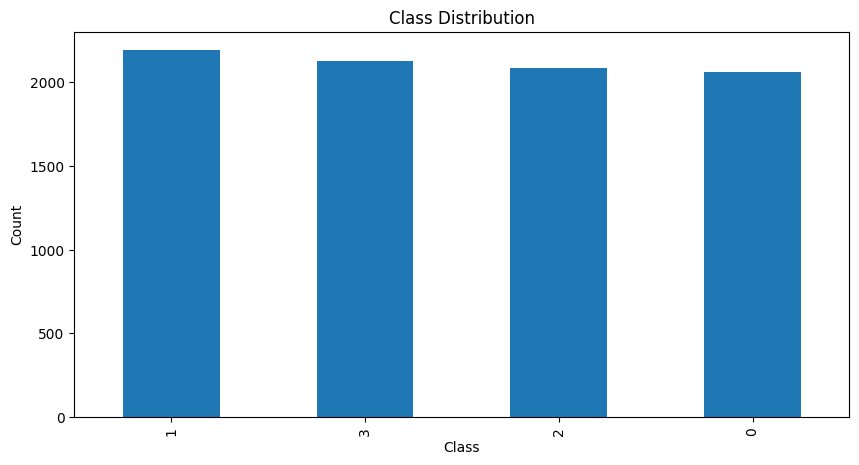

In [21]:
%pip install matplotlib
import matplotlib.pyplot as plt

# Calculate the value counts of the 'label' column
class_counts = df['label'].value_counts()

# Print the class counts
print(class_counts)

# Plot the class counts
plt.figure(figsize=(10,5))
class_counts.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()


In [22]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'clf__n_estimators': [50, 100],  # Reduced number of trees
    'clf__max_depth': [3, 5],  # Reduced max depth
    'clf__learning_rate': [0.1],  # Only one learning rate
}

# Create a pipeline
text_clf = Pipeline([
    ('tfidf', TfidfVectorizer(use_idf=True)),  # Only use IDF
    ('clf', xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', subsample=1, colsample_bytree=1)),  # Set subsample and colsample_bytree to 1
])

# Create a GridSearchCV object
grid_search = GridSearchCV(text_clf, param_grid, cv=2, n_jobs=-1)  # Reduced CV folds

# Fit the GridSearchCV object
grid_search.fit(X_train, y_train)

# Print the best parameters
print("Best parameters: ", grid_search.best_params_)

# Predict the test set results
y_pred = grid_search.predict(X_test)

# Print a classification report
print(classification_report(y_test, y_pred))


/Users/daaa/Downloads/KAKI-App/venv/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/daaa/Downloads/KAKI-App/venv/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/daaa/Downloads/KAKI-App/venv/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Best parameters:  {'clf__learning_rate': 0.1, 'clf__max_depth': 3, 'clf__n_estimators': 50}
              precision    recall  f1-score   support

           0       0.25      0.12      0.16       415
           1       0.27      0.40      0.33       459
           2       0.27      0.21      0.24       409
           3       0.21      0.27      0.24       411

    accuracy                           0.25      1694
   macro avg       0.25      0.25      0.24      1694
weighted avg       0.25      0.25      0.24      1694



In [32]:
import spacy

# Load the English model
nlp = spacy.load('en_core_web_sm')

def preprocess_text(text):
    # Create a Doc object
    doc = nlp(text)
    
    # Generate lemmas
    lemmas = [token.lemma_ for token in doc]
    
    # Remove stopwords and non-alphabetic characters
    a_lemmas = [lemma for lemma in lemmas 
            if lemma.isalpha() and lemma not in nlp.Defaults.stop_words]
    
    # Return preprocessed list of tokens
    return ' '.join(a_lemmas)

# Apply preprocessing to the text column
df['text'] = df['text'].apply(preprocess_text)


In [35]:
import spacy
from spacy.util import minibatch, compounding
from spacy.training import Example
from sklearn.model_selection import train_test_split

# Load a blank English model
nlp = spacy.blank('en')

# Add a text classifier to the pipeline
textcat = nlp.add_pipe('textcat')

# Add labels to the text classifier
for label in df['label'].unique():
    textcat.add_label(str(label))  # Ensure the label is a string

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.2, random_state=42)

# Convert the training data into the format required by spaCy
train_data = [Example.from_dict(nlp.make_doc(text), {'cats': {str(label): str(label) == str(y) for label in textcat.labels}}) for text, y in zip(X_train, y_train)]  # Create Example objects

# Initialize the model with the training data
nlp.initialize(lambda: train_data)

# Train the model
n_iter = 30
for i in range(n_iter):
    losses = {}
    batches = minibatch(train_data, size=compounding(4., 32., 1.001))
    for batch in batches:
        nlp.update(batch, losses=losses)
    print(f"Losses at iteration {i} - {losses}")

# Test the model
correct_predictions = 0
for doc, y in zip(X_test, y_test):
    doc = nlp(doc)
    predicted_label = max(doc.cats, key=doc.cats.get)
    if predicted_label == str(y):  # Ensure the label is a string
        correct_predictions += 1

# Print the accuracy
print(f"Accuracy: {correct_predictions / len(X_test)}")


Losses at iteration 0 - {'textcat': 195.7870711684227}
Losses at iteration 1 - {'textcat': 194.36518259346485}
Losses at iteration 2 - {'textcat': 185.678729750216}
Losses at iteration 3 - {'textcat': 160.92434392124414}
Losses at iteration 4 - {'textcat': 131.7278599087149}
Losses at iteration 5 - {'textcat': 108.90524978991016}
Losses at iteration 6 - {'textcat': 92.11912235555064}
Losses at iteration 7 - {'textcat': 78.28992322046497}
Losses at iteration 8 - {'textcat': 68.59683896085727}
Losses at iteration 9 - {'textcat': 61.993924266661665}
Losses at iteration 10 - {'textcat': 57.14530249284654}
Losses at iteration 11 - {'textcat': 50.806975998621546}
Losses at iteration 12 - {'textcat': 49.704976212866384}
Losses at iteration 13 - {'textcat': 46.27049130601455}
Losses at iteration 14 - {'textcat': 42.4917293401703}
Losses at iteration 15 - {'textcat': 42.37906326067315}
Losses at iteration 16 - {'textcat': 38.20284542011896}
Losses at iteration 17 - {'textcat': 37.84154337371674

In [31]:
df

,text,label
0,technical issue product setup im issue product...,3
1,technical issue peripheral compatibility im is...,3
2,technical issue network problem im facing prob...,0
3,billing inquiry account access im issue produc...,0
4,billing inquiry data loss im issue productpurc...,0
...,...,...
8464,product inquiry installation support productpu...,0
8465,technical issue refund request im issue produc...,3
8466,technical issue account access im issue produc...,2
8467,product inquiry payment issue im issue product...,1


In [39]:
df = df.rename(columns={"label": "target"})
df.head()

,text,target
0,technical issue product setup I m issue produc...,3
1,technical issue peripheral compatibility I m i...,3
2,technical issue network problem I m face probl...,0
3,bill inquiry account access I m issue productp...,0
4,bill inquiry datum loss I m issue productpurch...,0


In [40]:
df.to_csv("ticketClassifierV2.csv", index=False)

#### to summarize, SCREW THIS SHIT LETS TRY HF AUTOTRAIN
